In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from tensorflow.keras.layers import Input
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0
/device:GPU:0
Num GPUs Available:  1


In [ ]:
%cd /content/gdrive/MyDrive/cov_web_datset

/content/gdrive/MyDrive/cov_web_datset


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/cov_web_datset"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content/gdrive/MyDrive/cov_web_datset. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/gdrive/MyDrive/cov_web_datset'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
IMAGE_SIZE = 150
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [05:33,  7.45it/s]


(2481, 150, 150, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

In [ ]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg16_model.input, outputs=predictions)

# Freeze the layers of the pre-trained VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

optimizer = Adam(lr=0.0002)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model._name = "VGG16_Architecture"
model.summary()


58889256/58889256 [==============================] - 0s 0us/step


Model: "VGG16_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)

In [ ]:
training_datagen = ImageDataGenerator(rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        shear_range=0.2)

train_generator = training_datagen.flow(
	X_train, Y_train,
batch_size=64
)
training_datagen.fit(X_train)


filepath="VGG16_Model.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min',verbose=1)
callbacks_list = [checkpoint]

history = model.fit_generator(train_generator, steps_per_epoch=32, epochs=200,
                              validation_data=(X_val, Y_val),validation_steps=50,callbacks=callbacks_list)

<ipython-input-15-cc779e318060>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=32, epochs=200,


Epoch 1/200
32/32 [==============================] - ETA: 0s - loss: 0.7854 - accuracy: 0.6582
Epoch 1: val_loss improved from inf to 0.66901, saving model to VGG16_Model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 31s 487ms/step - loss: 0.7854 - accuracy: 0.6582 - val_loss: 0.6690 - val_accuracy: 0.5261
Epoch 2/200
32/32 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.7147
Epoch 2: val_loss improved from 0.66901 to 0.64650, saving model to VGG16_Model.hdf5
32/32 [==============================] - 19s 593ms/step - loss: 0.6391 - accuracy: 0.7147 - val_loss: 0.6465 - val_accuracy: 0.5622
Epoch 3/200
32/32 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.7025
Epoch 3: val_loss improved from 0.64650 to 0.62221, saving model to VGG16_Model.hdf5
32/32 [==============================] - 15s 474ms/step - loss: 0.6143 - accuracy: 0.7025 - val_loss: 0.6222 - val_accuracy: 0.6787
Epoch 4/200
32/32 [==============================] - ETA: 0s - loss: 0.5865 - accuracy: 0.7382
Epoch 4: val_loss improved from 0.62221 to 0.60107, saving model to VGG16_Model.hdf5
32/32 [==============================] - 15s 470ms/step - loss: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

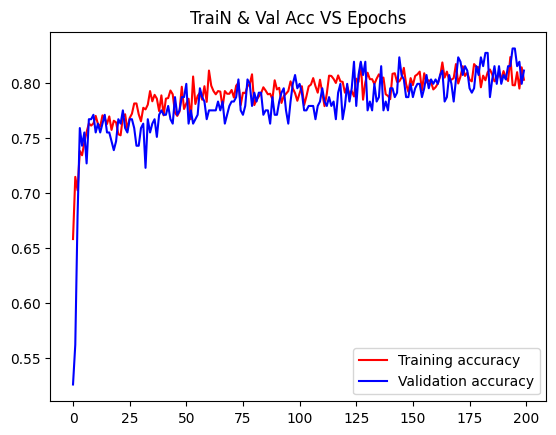

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

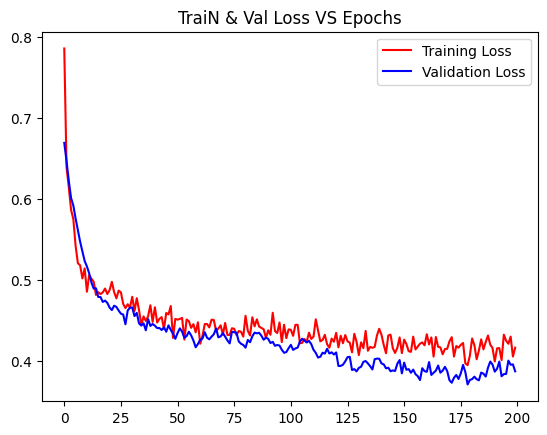

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Specify the path to the saved model file (replace 'my_model.h5' with the actual file path)
model_path = '/content/gdrive/MyDrive/cov_web_datset/ResNet50_Model.hdf5'

# Load the model
loaded_model = load_model(model_path)

# Now, you can use the loaded_model for predictions or further training


In [ ]:
model.load_weights("VGG16_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

8/8 [==============================] - 5s 359ms/step - loss: 0.3711 - accuracy: 0.8153
Test Loss: 0.37106066942214966
Test accuracy: 81.52610659599304


8/8 [==============================] - 1s 64ms/step


Text(0.5, 1.0, 'Confusion Matrix')

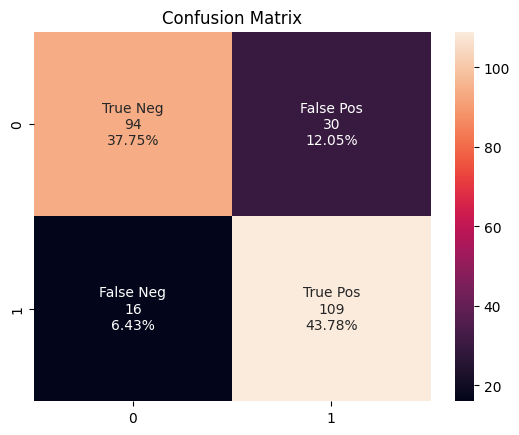

In [ ]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the pre-trained model
model_path = '/content/gdrive/MyDrive/cov_web_datset/Copy of VGG16_Model.hdf5'
model = load_model(model_path)

# Load and preprocess the image
path = "/content/gdrive/MyDrive/cov_web_datset/non-COVID/Non-Covid (100).png"
img = image.load_img(path, target_size=(150, 150))  # Resize to match the model's input shape
img = image.img_to_array(img) / 255.0
img = np.array([img])

# Make predictions
predictions = model.predict(img)

# Set a threshold for binary classification
threshold = 0.5
if predictions[0][0] >= threshold:
    result = "COVID: Positive"
else:
    result = "COVID: Negative"

print(f'The image is classified as: {result}')


1/1 [==============================] - 0s 178ms/step
The image is classified as: COVID: Negative
